# Explore the ESC dataset

## Introduction
This notebook acts as the exploration of the dataset

## Goal 
Idea of the implementation, is to first look at the dataset and then create a new dataset that summarizes the data into something more suited for the "winner"-classification.

Potential columns:
1. Year, numeric <- what year
2. Country, numeric <- numeric country code
2. Semifinal, binary <- is it a semifinal?
3. Final, binary <- is it the final?
4. (**target**) Won, binary <- Did the country win?

### Additional notes
* We want the classifier to give probabilites.
* Give a prediction for this years ESC, how close were we?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("../DATA/eurovision_song_contest_1975_2018v2.csv")

In [3]:
data.head()

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,1975,f,1975f,J,Belgium,France,2,NaN
3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,1975,f,1975f,J,Belgium,Ireland,12,NaN


In [4]:
data.shape

(46382, 8)

In [5]:
data.isnull().sum()

Year                      0
(semi-) final             0
Edition                   0
Jury or Televoting        0
From country              0
To country                0
Points                    0
Duplicate             44980
dtype: int64

**1403 rows are duplicate?**

In [6]:
data.dtypes

Year                   int64
(semi-) final         object
Edition               object
Jury or Televoting    object
From country          object
To country            object
Points                 int64
Duplicate             object
dtype: object

**looks like we will have to do some dummy-variables** 

# Understanding the different columns

## Year
At what year was the competition?

## (semi-) final
Was it finals or semifinals?
* f final
* sfX semi-final X

## Edition
concatenaed column of Year and (semi-)final column?
* YYYYFF, YYYY <- year, FF <- f or sfX

## Jury or Televoting
From where were the points assigned?
* J, jury
* T, Televoting

## From country
Which country gave the points
* "European country"
Maybe check if there has been any namechanges?

## To country
Which country recieved the points?
* "European contry"
**Assign numeric country codes instead of names?**

## Points
The number of points given

## Duplicate
is it country X to country X?
* x, yes
* NaN, no

In [7]:
data.loc[~data.Duplicate.isnull(),].head()

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
0,1975,f,1975f,J,Belgium,Belgium,0,x
20,1975,f,1975f,J,Finland,Finland,0,x
40,1975,f,1975f,J,France,France,0,x
60,1975,f,1975f,J,Germany,Germany,0,x
80,1975,f,1975f,J,Ireland,Ireland,0,x


In [8]:
out = data.loc[~data.Duplicate.isnull(),].apply(lambda x: 1 if x["From country"] == x["To country"] else 0, axis=1)

In [9]:
out.mean()

1.0

**We should be able to drop these columns!**

In [10]:
data = data.loc[data.Duplicate.isnull(),data.columns[:-1]]

In [11]:
data.head()

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points
1,1975,f,1975f,J,Belgium,Finland,0
2,1975,f,1975f,J,Belgium,France,2
3,1975,f,1975f,J,Belgium,Germany,0
4,1975,f,1975f,J,Belgium,Ireland,12
5,1975,f,1975f,J,Belgium,Israel,1


# Explore the total number of points!
*hue with the type of points*

In [12]:
# clean out trailing whitespaces!
data.columns = [d.strip() for d in data.columns]

### The average number of points given (per country to country)

In [13]:
data_final = data.loc[data["(semi-) final"] == "f",]

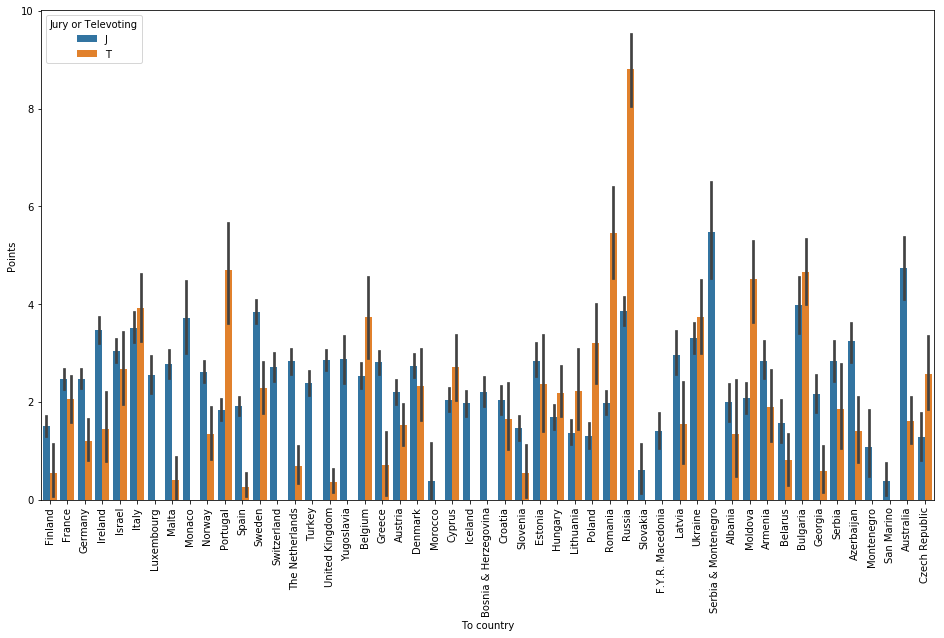

In [14]:
plt.figure(figsize=[16,9])
sns.barplot(data=data_final, x="To country", y="Points", hue="Jury or Televoting")
plt.xticks(rotation='vertical')
pass

### the total number of points recieved?

In [15]:
total_points = data_final.groupby(["To country", "Jury or Televoting"], as_index=False).Points.sum()
total_points.head()

,To country,Jury or Televoting,Points
0,Albania,J,630
1,Albania,T,58
2,Armenia,J,1121
3,Armenia,T,155
4,Australia,J,777


**should normalize the points, to its nicer to compare in plotting**

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler_j = MinMaxScaler()
scaler_t = MinMaxScaler()

In [17]:
Jpoints =scaler_j.fit_transform(np.array(total_points.loc[total_points["Jury or Televoting"] == "J",["Points"]]).reshape(-1,1))
Tpoints =scaler_t.fit_transform(np.array(total_points.loc[total_points["Jury or Televoting"] == "T",["Points"]]).reshape(-1,1))

/home/rober323/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/rober323/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [18]:
total_points.loc[total_points["Jury or Televoting"] == "J",["Points"]] = Jpoints
total_points.loc[total_points["Jury or Televoting"] == "T",["Points"]] = Tpoints

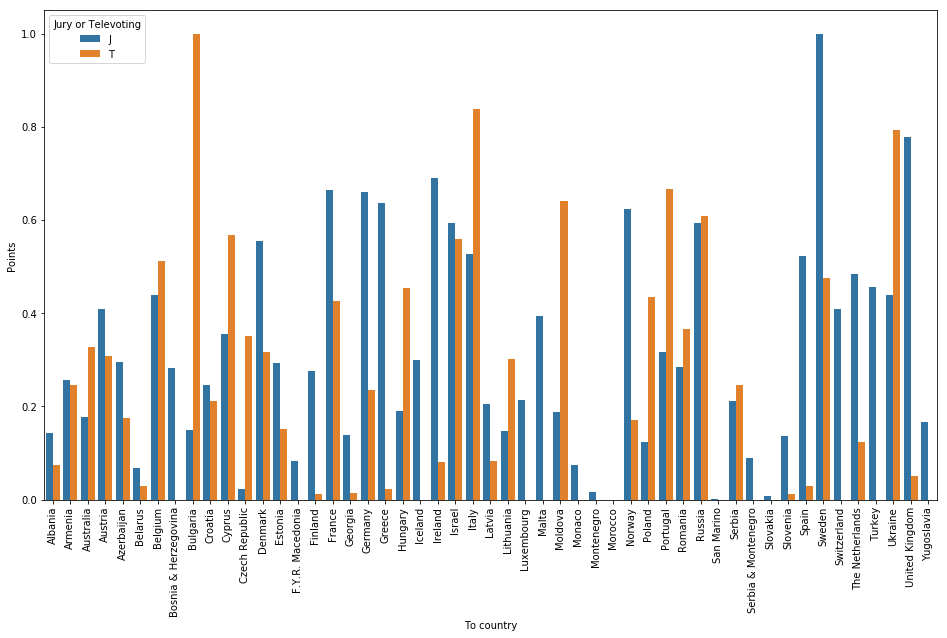

In [19]:
plt.figure(figsize=[16,9])
sns.barplot(data=total_points,
            x="To country",y="Points", hue="Jury or Televoting")
plt.xticks(rotation='vertical')
pass

### If we just group together all points

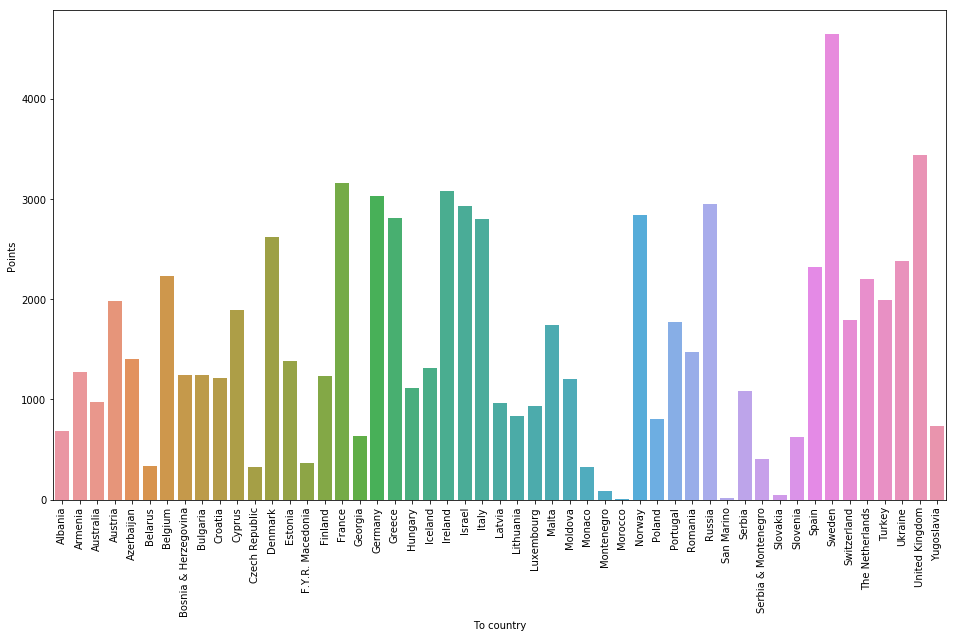

In [20]:
total_points = data_final.groupby(["To country"], as_index=False).Points.sum()

plt.figure(figsize=[16,9])
sns.barplot(data=total_points,x="To country", y="Points")
plt.xticks(rotation="vertical")
pass

## How many wins are there?
Per year and final, which country had the most points? <-- Winner
How many wins per country?

In [21]:
dt_group = data_final.groupby(["Year","To country"])["Points"].sum()

In [22]:
winnerid = dt_group.reset_index().groupby(["Year"])["Points"].apply(lambda x: x.idxmax())
winners = dt_group[winnerid].reset_index()
winners["To country"].value_counts()

Ireland            6
Sweden             4
Israel             4
United Kingdom     3
Norway             3
Germany            2
Ukraine            2
Denmark            2
France             2
Luxembourg         1
Russia             1
Yugoslavia         1
Latvia             1
Azerbaijan         1
Estonia            1
Turkey             1
Greece             1
Portugal           1
The Netherlands    1
Serbia             1
Switzerland        1
Austria            1
Italy              1
Belgium            1
Finland            1
Name: To country, dtype: int64

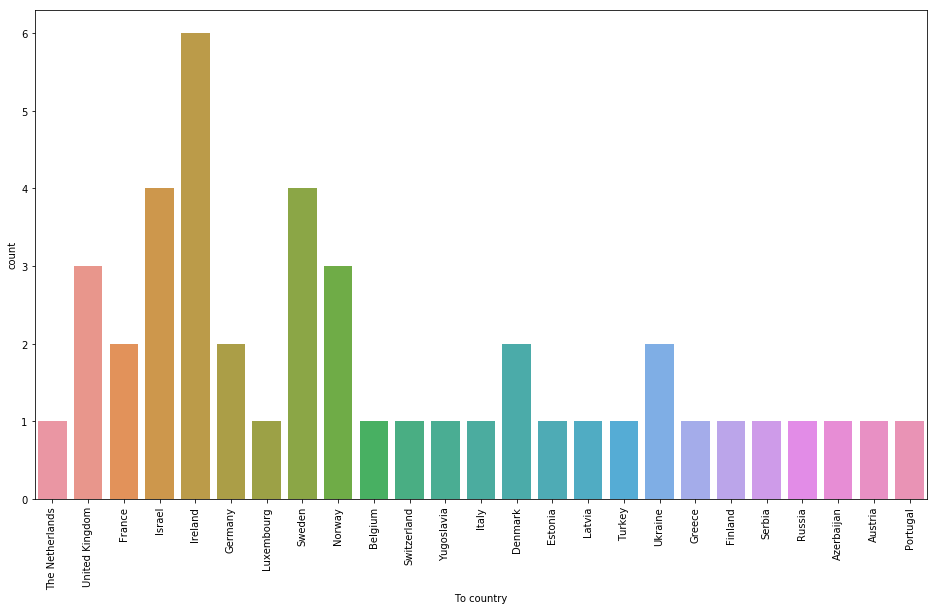

In [23]:
plt.figure(figsize=[16,9])
sns.countplot(data=winners, x= "To country")
plt.xticks(rotation="vertical")
pass

In [24]:
winners.head()

,Year,To country,Points
0,1975,The Netherlands,152
1,1976,United Kingdom,164
2,1977,France,136
3,1978,Israel,157
4,1979,Israel,125


### create a new dataframe
which holds columns
* year (numeric)
* country_id (numeric)
* win (numeric)

### and a countries dataframe
* country_id 
* name

In [60]:
# construct the different arrays
country_uniq = data["From country"].unique()
d = {"country_id": np.arange(len(country_uniq)),
     "name": country_uniq}

countries = pd.DataFrame(data=d)
countries.head()

,country_id,name
0,0,Belgium
1,1,Finland
2,2,France
3,3,Germany
4,4,Ireland


In [166]:
years = np.array(winners.Year)
win = np.zeros(len(years)*countries.shape[0])

# for each year, we want the countries
year_rep = np.repeat(years, countries.shape[0])
countries_tile = np.tile(countries.index,len(years))

winData = pd.DataFrame(data={"year":year_rep, "country_id": countries_tile, "win":win}, 
                       dtype="int32")

year_country_id = winners.join(countries.set_index("name"), on="To country")[["Year","country_id"]]

In [167]:
# iterate over each years winner

for index in range(year_country_id.shape[0]):
    year, country_id = year_country_id.iloc[index,:]
    # and say if the country won or not!
    winData.loc[(winData.country_id == country_id) & (winData.year == year), "win"] = 1

In [168]:
winData.head()

,country_id,win,year
0,0,0,1975
1,1,0,1975
2,2,0,1975
3,3,0,1975
4,4,0,1975


# do a dummy ML approach!

In [180]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression



In [193]:
X_train, X_test, y_train, y_test = train_test_split(winData.drop(columns=["win"]),
                                                   winData.win, random_state=42, 
                                                   test_size=0.3, stratify=winData.win)

In [194]:
# design model
model = LogisticRegression()

# fit model
model.fit(X_train,y_train)

# predict with model
y_pred = model.predict(X_test)

/home/rober323/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### How well does it perform?


In [188]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [195]:
accuracy_score(y_pred, y_test)

0.9817671809256662

In [196]:
winData.win.unique()

array([0, 1])

In [201]:
confusion_matrix(y_pred,y_test)

array([[700,  13],
       [  0,   0]])

In [174]:
x = X_test.join(y_test)
x["pred"] = y_pred

In [175]:
x.sort_values("year")

,country_id,year,win,pred
25,25,1975,0,0
44,44,1975,0,0
43,43,1975,0,0
29,29,1975,0,0
8,8,1975,0,0
23,23,1975,0,0
20,20,1975,0,0
18,18,1975,0,0
49,49,1975,0,0
48,48,1975,0,0


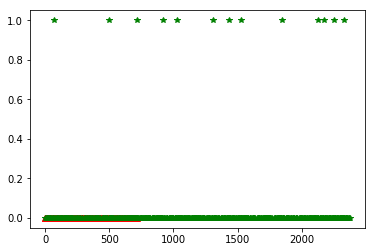

In [198]:
plt.plot(y_pred,'r^')
plt.plot(y_test,'g*')

In [200]:
y_pred.
value_counts()

0    700
1     13
Name: win, dtype: int64